# Module 7 — Manual K-Means (Step-by-Step)

This notebook is a dedicated **by-hand walkthrough** of K-Means clustering.
We use a tiny dataset (Height, Weight) and manually perform each step before verifying with code.

## Learning goals
- Understand K-Means objective and notation.
- Compute assignments and centroid updates manually.
- Track convergence and objective decrease across iterations.
- Visualize each iteration and interpret final clusters.

## 1) K-Means idea and notation
Given data points $x_i \in \mathbb{R}^d$ and a chosen number of clusters $k$, K-Means tries to minimize the total within-cluster squared distance:
$$
J = \sum_{i=1}^{n} \min_{1 \le j \le k} \lVert x_i - \mu_j \rVert^2
$$
where $\mu_j$ is the centroid of cluster $j$.

### Iteration notation
- $\mu_j^{(0)}$: initial centroid $j$ (before any update)
- $\mu_j^{(1)}$: centroid $j$ after the first update
- In general, superscript $(t)$ means the centroid at iteration $t$.

## 2) Tiny dataset (Height, Weight)
We cluster six points into $k=2$ groups.

| Point | Height (cm) | Weight (kg) |
|---|---:|---:|
| A | 150 | 50 |
| B | 152 | 54 |
| C | 158 | 59 |
| D | 170 | 72 |
| E | 172 | 75 |
| F | 175 | 78 |

### Initialization (define every symbol)

- $\mu$ (mu) means a **centroid** (cluster center).
- Subscript in $\mu_j$ identifies cluster number $j$ (for example, $j=1,2$).
- Superscript in $\mu_j^{(t)}$ is the iteration index $t$.
- So $\mu_1^{(0)}$ is centroid 1 at iteration 0 (initialization), before any update.

For this example, we start with:
$$
\mu_1^{(0)}=(150,50),\qquad \mu_2^{(0)}=(170,72)
$$

Interpretation of all common symbols used in this notebook:
- $\mu_1^{(0)}$: centroid 1 at iteration 0 (initial value).
- $\mu_1^{(1)}$: centroid 1 after the first update (here it becomes approximately $(153.33, 54.33)$).
- $\mu_2^{(0)}$: centroid 2 at iteration 0 (initial value).
- $\mu_2^{(1)}$: centroid 2 after the first update (here it becomes approximately $(172.33, 75.00)$).

Coordinate meaning:
- $(150,50)$ means Height = 150 cm and Weight = 50 kg for centroid 1.
- $(170,72)$ means Height = 170 cm and Weight = 72 kg for centroid 2.

,Point,Height,Weight
0,A,150.0,50.0
1,B,152.0,54.0
2,C,158.0,59.0
3,D,170.0,72.0
4,E,172.0,75.0
5,F,175.0,78.0


Initial centroids (iteration t=0):


,Height,Weight
Centroid 1 (t=0),150.0,50.0
Centroid 2 (t=0),170.0,72.0


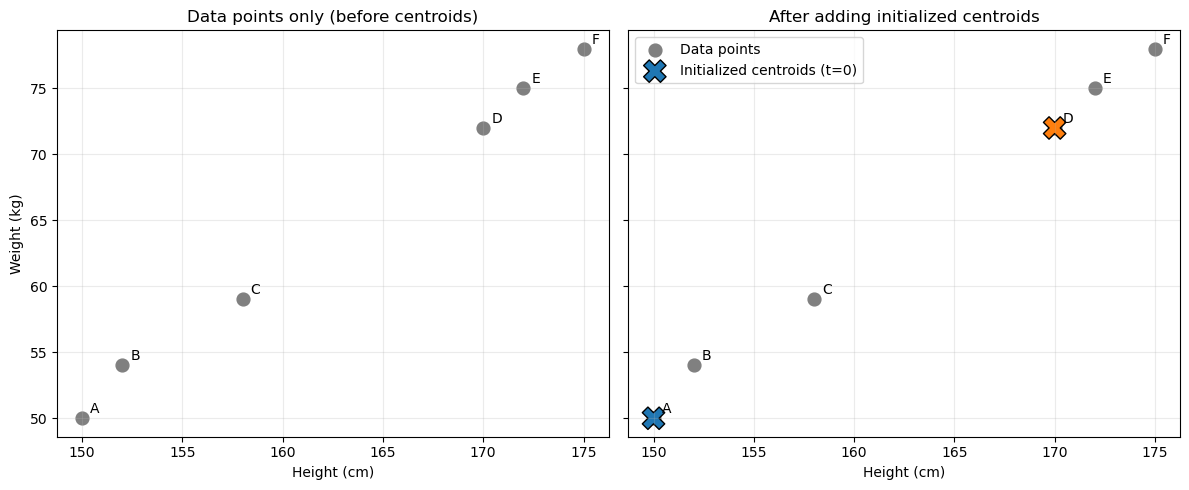

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

point_names = np.array(['A','B','C','D','E','F'])
X = np.array([
    [150, 50],
    [152, 54],
    [158, 59],
    [170, 72],
    [172, 75],
    [175, 78]
], dtype=float)

C_init = np.array([[150, 50], [170, 72]], dtype=float)

df_points = pd.DataFrame(X, columns=['Height','Weight'])
df_points.insert(0, 'Point', point_names)
display(df_points)

centroids_init_df = pd.DataFrame(
    C_init,
    index=['Centroid 1 (t=0)', 'Centroid 2 (t=0)'],
    columns=['Height', 'Weight']
).round(2)

print('Initial centroids (iteration t=0):')
display(centroids_init_df)

# Visualize data before and after adding initialized centroids
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Before centroids
axes[0].scatter(X[:, 0], X[:, 1], color='gray', s=85)
for name, (x, y) in zip(point_names, X):
    axes[0].text(x + 0.4, y + 0.4, name, fontsize=10)
axes[0].set_title('Data points only (before centroids)')
axes[0].set_xlabel('Height (cm)')
axes[0].set_ylabel('Weight (kg)')
axes[0].grid(alpha=0.25)

# After adding initialized centroids
axes[1].scatter(X[:, 0], X[:, 1], color='gray', s=85, label='Data points')
for name, (x, y) in zip(point_names, X):
    axes[1].text(x + 0.4, y + 0.4, name, fontsize=10)
axes[1].scatter(
    C_init[:, 0], C_init[:, 1],
    marker='X', s=260,
    c=['tab:blue', 'tab:orange'],
    edgecolor='black',
    label='Initialized centroids (t=0)'
)
axes[1].set_title('After adding initialized centroids')
axes[1].set_xlabel('Height (cm)')
axes[1].grid(alpha=0.25)
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 3) Step 1: Assignment using centroids at t=0
Compute distances from each point to both initialized centroids and assign each point to the nearest centroid.

,Point,Height,Weight,Distance to Centroid 1 (t=0),Distance to Centroid 2 (t=0),Assigned Cluster (1 or 2)
0,A,150.0,50.0,0.000,29.732,1
1,B,152.0,54.0,4.472,25.456,1
2,C,158.0,59.0,12.042,17.692,1
3,D,170.0,72.0,29.732,0.000,2
4,E,172.0,75.0,33.302,3.606,2
5,F,175.0,78.0,37.537,7.810,2


Points assigned to Centroid 1 (t=0): ['A' 'B' 'C']
Points assigned to Centroid 2 (t=0): ['D' 'E' 'F']
Objective J at t=0: 239.0


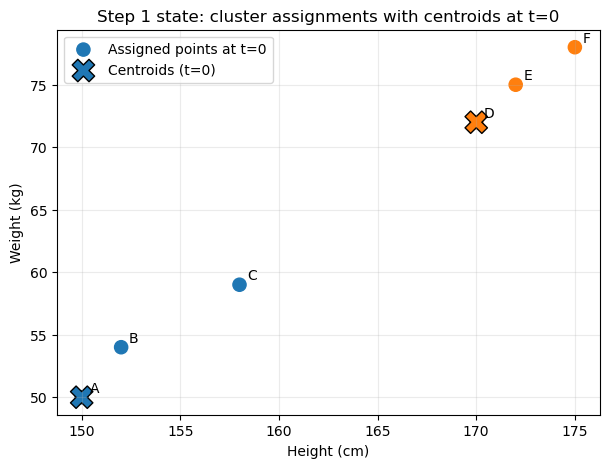

In [6]:
# Centroids at iteration t=0
C_t0 = C_init.copy()

# Distance from each point to each centroid (explicit formulas)
d_to_c1_t0 = np.sqrt((X[:, 0] - C_t0[0, 0])**2 + (X[:, 1] - C_t0[0, 1])**2)
d_to_c2_t0 = np.sqrt((X[:, 0] - C_t0[1, 0])**2 + (X[:, 1] - C_t0[1, 1])**2)

# Assign to nearest centroid (0 for centroid 1, 1 for centroid 2)
labels0 = np.where(d_to_c1_t0 <= d_to_c2_t0, 0, 1)

# Objective at t=0
J_t0 = float(np.sum(np.where(labels0 == 0, d_to_c1_t0**2, d_to_c2_t0**2)))

table0 = pd.DataFrame({
    'Point': point_names,
    'Height': X[:, 0],
    'Weight': X[:, 1],
    'Distance to Centroid 1 (t=0)': np.round(d_to_c1_t0, 3),
    'Distance to Centroid 2 (t=0)': np.round(d_to_c2_t0, 3),
    'Assigned Cluster (1 or 2)': labels0 + 1
})
display(table0)

print('Points assigned to Centroid 1 (t=0):', point_names[labels0 == 0])
print('Points assigned to Centroid 2 (t=0):', point_names[labels0 == 1])
print('Objective J at t=0:', round(J_t0, 3))

# Visualization at this state (t=0): assigned clusters + centroids
colors_t0 = np.where(labels0 == 0, 'tab:blue', 'tab:orange')
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=colors_t0, s=90, label='Assigned points at t=0')
plt.scatter(
    C_t0[:, 0], C_t0[:, 1],
    marker='X', s=260,
    c=['tab:blue', 'tab:orange'],
    edgecolor='black',
    label='Centroids (t=0)'
)

for name, (x, y) in zip(point_names, X):
    plt.text(x + 0.4, y + 0.4, name, fontsize=10)

plt.title('Step 1 state: cluster assignments with centroids at t=0')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.grid(alpha=0.25)
plt.legend(loc='best')
plt.show()

### Why is $J_{t=0}=239$? (and what is inertia?)

At iteration $t=0$, each point is assigned to its nearest centroid.  
The objective is the sum of squared distances to assigned centroids:

$$
J_{t=0} = \sum_i \lVert x_i - \mu_{c(i)} \rVert^2
$$

Using our assignments:

- A $\to$ Centroid 1: $(150-150)^2 + (50-50)^2 = 0$
- B $\to$ Centroid 1: $(152-150)^2 + (54-50)^2 = 4 + 16 = 20$
- C $\to$ Centroid 1: $(158-150)^2 + (59-50)^2 = 64 + 81 = 145$
- D $\to$ Centroid 2: $(170-170)^2 + (72-72)^2 = 0$
- E $\to$ Centroid 2: $(172-170)^2 + (75-72)^2 = 4 + 9 = 13$
- F $\to$ Centroid 2: $(175-170)^2 + (78-72)^2 = 25 + 36 = 61$

So:

$$
J_{t=0} = 0 + 20 + 145 + 0 + 13 + 61 = 239
$$

### Inertia connection

In scikit-learn, **inertia** is exactly this same quantity at the final clustering state:

$$
\text{inertia} = \sum_i \lVert x_i - \mu_{c(i)} \rVert^2
$$
 
As K-Means iterates, this value should stay the same or decrease until convergence.

## 4) Step 2: Update centroids from t=0 to t=1
Each updated centroid is the mean of points assigned to that centroid in Step 1.

Updated centroids after Step 2:


,Height,Weight
Centroid 1 (t=1),153.333,54.333
Centroid 2 (t=1),172.333,75.000


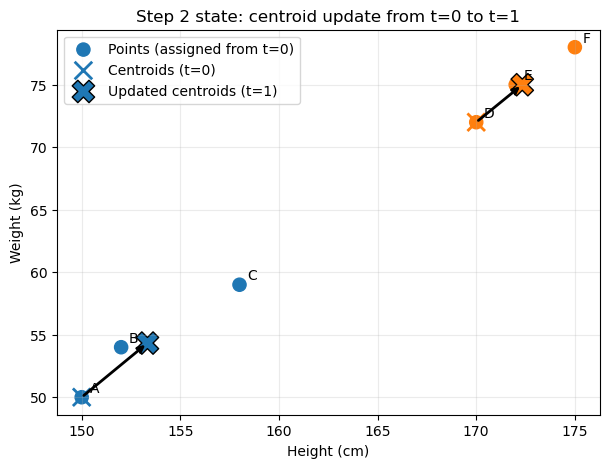

In [7]:
# Step 2: compute new centroids from Step 1 assignments
# - Centroid 1 (t=1) = mean of points assigned to cluster 1 at t=0
# - Centroid 2 (t=1) = mean of points assigned to cluster 2 at t=0
C_t1 = np.vstack([
    X[labels0 == 0].mean(axis=0),
    X[labels0 == 1].mean(axis=0)
])

# Show the updated centroid coordinates in a clean table
centroids_t1_df = pd.DataFrame(
    C_t1,
    index=['Centroid 1 (t=1)', 'Centroid 2 (t=1)'],
    columns=['Height', 'Weight']
).round(3)

print('Updated centroids after Step 2:')
display(centroids_t1_df)

# Visualization for Step 2 state: points + old/new centroids
colors_t1_state = np.where(labels0 == 0, 'tab:blue', 'tab:orange')
plt.figure(figsize=(7, 5))

# Points remain colored by assignments from Step 1 (used to compute t=1 centroids)
plt.scatter(X[:, 0], X[:, 1], c=colors_t1_state, s=90, label='Points (assigned from t=0)')

# Previous centroids at t=0
plt.scatter(
    C_t0[:, 0], C_t0[:, 1],
    marker='x', s=160, c=['tab:blue', 'tab:orange'], linewidth=2,
    label='Centroids (t=0)'
)

# Updated centroids at t=1
plt.scatter(
    C_t1[:, 0], C_t1[:, 1],
    marker='X', s=260, c=['tab:blue', 'tab:orange'], edgecolor='black',
    label='Updated centroids (t=1)'
)

# Show centroid movement arrows
for j in range(2):
    plt.annotate(
        '',
        xy=C_t1[j], xytext=C_t0[j],
        arrowprops=dict(arrowstyle='->', lw=2, color='black')
    )

for name, (x, y) in zip(point_names, X):
    plt.text(x + 0.4, y + 0.4, name, fontsize=10)

plt.title('Step 2 state: centroid update from t=0 to t=1')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.grid(alpha=0.25)
plt.legend(loc='best')
plt.show()

## 5) Step 3: Re-assignment using centroids at t=1
Recompute distances to the updated centroids. If assignments do not change, K-Means has converged.

,Point,Distance to Centroid 1 (t=1),Distance to Centroid 2 (t=1),Assigned Cluster (1 or 2)
0,A,5.467,33.523,1
1,B,1.374,29.231,1
2,C,6.600,21.481,1
3,D,24.288,3.801,2
4,E,27.849,0.333,2
5,F,32.087,4.014,2


Assignments changed from t=0 to t=1? False
Objective J at t=1: 106.0


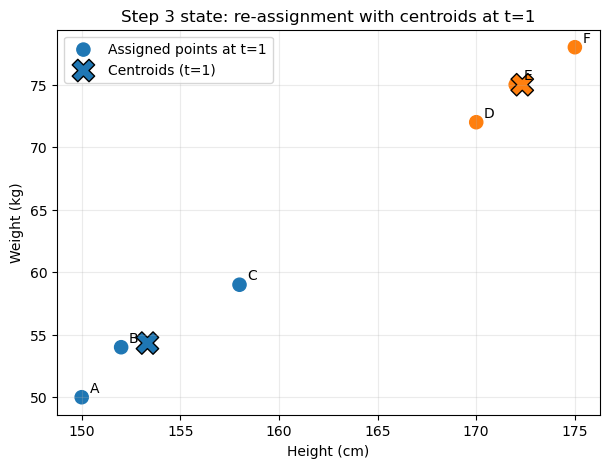

In [8]:
# Re-assignment using centroids at t=1
d_to_c1_t1 = np.sqrt((X[:, 0] - C_t1[0, 0])**2 + (X[:, 1] - C_t1[0, 1])**2)
d_to_c2_t1 = np.sqrt((X[:, 0] - C_t1[1, 0])**2 + (X[:, 1] - C_t1[1, 1])**2)
labels1 = np.where(d_to_c1_t1 <= d_to_c2_t1, 0, 1)

J_t1 = float(np.sum(np.where(labels1 == 0, d_to_c1_t1**2, d_to_c2_t1**2)))

table1 = pd.DataFrame({
    'Point': point_names,
    'Distance to Centroid 1 (t=1)': np.round(d_to_c1_t1, 3),
    'Distance to Centroid 2 (t=1)': np.round(d_to_c2_t1, 3),
    'Assigned Cluster (1 or 2)': labels1 + 1
})
display(table1)

print('Assignments changed from t=0 to t=1?', not np.array_equal(labels0, labels1))
print('Objective J at t=1:', round(J_t1, 3))

# Visualization for Step 3 state: re-assigned clusters + centroids at t=1
colors_t1 = np.where(labels1 == 0, 'tab:blue', 'tab:orange')
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=colors_t1, s=90, label='Assigned points at t=1')
plt.scatter(
    C_t1[:, 0], C_t1[:, 1],
    marker='X', s=260,
    c=['tab:blue', 'tab:orange'],
    edgecolor='black',
    label='Centroids (t=1)'
)

for name, (x, y) in zip(point_names, X):
    plt.text(x + 0.4, y + 0.4, name, fontsize=10)

plt.title('Step 3 state: re-assignment with centroids at t=1')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.grid(alpha=0.25)
plt.legend(loc='best')
plt.show()

## 7) Full iteration loop until convergence
Now run the exact K-Means loop to show all iterations and objective decrease.

In [5]:
k = 2
C_current = C_init.copy()
history = []

for t in range(10):
    # Distances to current centroids (explicit, no helper functions)
    dmat = np.sqrt(np.sum((X[:, None, :] - C_current[None, :, :])**2, axis=2))
    labels = np.argmin(dmat, axis=1)
    J = float(np.sum(np.min(dmat**2, axis=1)))

    history.append({
        'iter': t,
        'centroids': C_current.copy(),
        'labels': labels.copy(),
        'J': J
    })

    # Update centroids directly from assigned groups
    C_next = np.vstack([
        X[labels == 0].mean(axis=0),
        X[labels == 1].mean(axis=0)
    ])

    if np.allclose(C_next, C_current):
        break
    C_current = C_next

# Iteration summary table
summary_rows = []
for h in history:
    summary_rows.append({
        'Iteration t': h['iter'],
        'Centroid 1 (t)': f"({h['centroids'][0,0]:.3f}, {h['centroids'][0,1]:.3f})",
        'Centroid 2 (t)': f"({h['centroids'][1,0]:.3f}, {h['centroids'][1,1]:.3f})",
        'Objective J': round(h['J'], 3)
    })
hist_df = pd.DataFrame(summary_rows)
display(hist_df)

# Long-format centroid table with explicit labels requested
centroid_rows = []
for h in history:
    centroid_rows.append({
        'Centroid Label': f"Centroid 1 (t={h['iter']})",
        'Height': round(h['centroids'][0, 0], 3),
        'Weight': round(h['centroids'][0, 1], 3)
    })
    centroid_rows.append({
        'Centroid Label': f"Centroid 2 (t={h['iter']})",
        'Height': round(h['centroids'][1, 0], 3),
        'Weight': round(h['centroids'][1, 1], 3)
    })
centroid_table = pd.DataFrame(centroid_rows)
display(centroid_table)

print('Final labels (1-based):', history[-1]['labels'] + 1)
print('Final centroids:\n', np.round(history[-1]['centroids'], 3))

,Iteration t,Centroid 1 (t),Centroid 2 (t),Objective J
0,0,"(150.000, 50.000)","(170.000, 72.000)",239.0
1,1,"(153.333, 54.333)","(172.333, 75.000)",106.0


,Centroid Label,Height,Weight
0,Centroid 1 (t=0),150.000,50.000
1,Centroid 2 (t=0),170.000,72.000
2,Centroid 1 (t=1),153.333,54.333
3,Centroid 2 (t=1),172.333,75.000


Final labels (1-based): [1 1 1 2 2 2]
Final centroids:
 [[153.333  54.333]
 [172.333  75.   ]]


### Interpretation of the final result

Final labels (1-based): `[1, 1, 1, 2, 2, 2]` means:

- **Cluster 1** contains points **A, B, C**.
- **Cluster 2** contains points **D, E, F**.

Final centroids:

$$
\mu_1 = (153.333,\;54.333), \qquad \mu_2 = (172.333,\;75.000)
$$

Interpretation:

- The first cluster center is around **153.3 cm height** and **54.3 kg weight** (lower-height/lower-weight group).
- The second cluster center is around **172.3 cm height** and **75.0 kg weight** (higher-height/higher-weight group).
- The groups are clearly separated, so K-Means found two compact and meaningful clusters in this toy dataset.

This also confirms convergence behavior: once assignments stabilize as `[1,1,1,2,2,2]`, centroid updates stop changing significantly.